# Kidney Stone Risk Prediction — Exploratory Data Analysis (EDA)

This notebook performs an initial exploratory analysis of the dataset used to predict the risk of kidney stone formation.  
The goal is to understand the distribution of clinical and biochemical variables, detect anomalies, review physiological ranges, and identify preliminary patterns associated with stone risk.

**Dataset:** Kidney Stones Prediction Dataset (Omar Ayman, Kaggle)  
https://www.kaggle.com/datasets/omarayman15/kidney-stones


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from pathlib import Path

pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 160)


In [2]:
# Load dataset
DATA_PATH = Path("../data/raw/cleaned_stone.csv")
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
df.head()


Shape: (4000, 24)


,serum_creatinine,gfr,bun,serum_calcium,ana,c3_c4,hematuria,oxalate_levels,urine_ph,blood_pressure,physical_activity,diet,water_intake,smoking,alcohol,painkiller_usage,family_history,weight_changes,stress_level,months,cluster,ckd_pred,ckd_stage,stone_risk
0,0.683683,32.946784,7.553739,10.039896,0,138.204989,0,2.878164,7.864308,115.224217,weekly,high protein,2.314979,yes,daily,no,yes,stable,low,10,5,CKD,3,1
1,3.809044,32.685035,141.347494,8.330543,1,24.282343,1,4.767639,4.920015,130.143900,weekly,high protein,2.250649,yes,daily,no,yes,loss,moderate,1,2,CKD,3,1
2,1.143827,2.079805,15.979104,9.419229,0,163.970666,0,1.818613,6.188115,98.026072,weekly,low salt,2.542343,no,daily,no,no,stable,moderate,4,6,CKD,5,0
3,4.804657,109.871407,53.307333,7.556631,1,71.056846,1,4.051686,5.278607,142.166650,rarely,low salt,2.640812,no,never,yes,yes,stable,high,9,2,CKD,1,1
4,4.920235,42.214590,134.182157,7.289379,1,23.384639,1,3.240920,4.862923,151.962572,weekly,balanced,3.148921,no,occasionally,yes,no,gain,high,7,2,CKD,3,1


In [3]:
# Target distribution
assert 'stone_risk' in df.columns
df['stone_risk'].value_counts(normalize=True).round(3)


stone_risk
0    0.608
1    0.392
Name: proportion, dtype: float64

In [4]:
# Summary ranges for key variables
def rstats(s):
    s = s.dropna()
    return pd.Series({
        'min': s.min(),
        'p1': s.quantile(0.01),
        'median': s.median(),
        'p99': s.quantile(0.99),
        'max': s.max()
    })

candidate_vars = [
    c for c in [
        'urine_ph', 'water_intake', 'blood_pressure', 'serum_calcium',
        'gfr', 'bun', 'serum_creatinine', 'oxalate_levels'
    ] if c in df.columns
]

summary_table = pd.concat({c: rstats(df[c]) for c in candidate_vars}, axis=1) 
display(summary_table)

# Save summary table
os.makedirs("../reports/tables", exist_ok=True)

summary_table.to_csv('../reports/tables/summary_ranges.csv')
print("Saved summary table to ../reports/tables/summary_ranges.csv")


,urine_ph,water_intake,blood_pressure,serum_calcium,gfr,bun,serum_creatinine,oxalate_levels
min,4.500576,1.500627,90.019471,5.002407,0.021317,7.000920,0.500273,1.000852
p1,4.540933,1.517954,90.523202,5.121665,0.924264,7.161127,0.509646,1.033007
median,6.579063,2.512182,111.113002,8.982200,50.247075,16.296667,0.993766,2.432659
p99,7.971747,3.472388,177.900565,10.179000,118.223231,146.758569,4.867531,4.944828
max,7.999886,3.499595,179.991991,10.199344,119.923482,149.999395,4.994009,4.999965


Saved summary table to ../reports/tables/summary_ranges.csv


Saved histogram for urine_ph → ../reports/figures/histogram_urine_ph.png


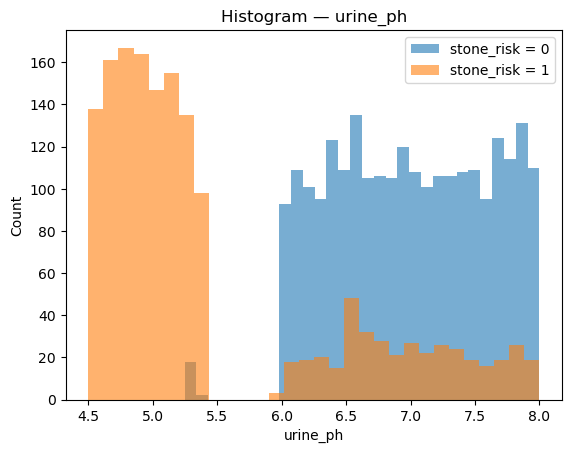

Saved histogram for oxalate_levels → ../reports/figures/histogram_oxalate_levels.png


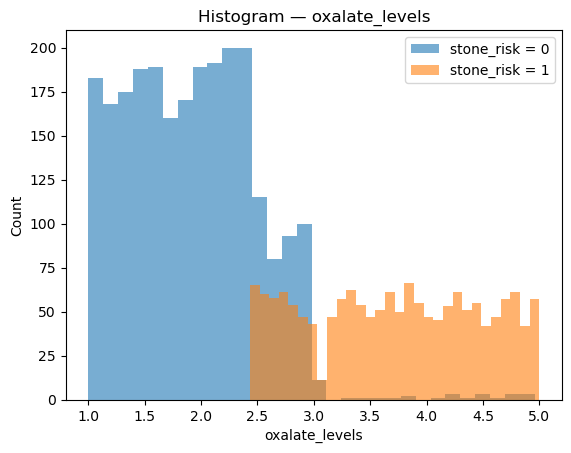

Saved histogram for water_intake → ../reports/figures/histogram_water_intake.png


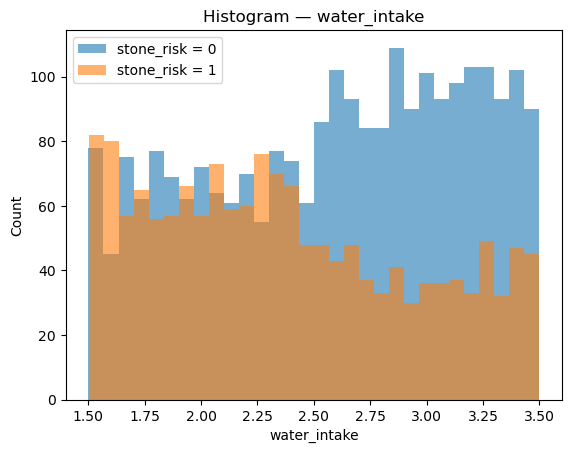

In [5]:
# Histograms by class
os.makedirs("../reports/figures", exist_ok=True)

for c in ['urine_ph', 'oxalate_levels', 'water_intake']:
    if c in df.columns:
        plt.figure()
        plt.hist(df.loc[df['stone_risk'] == 0, c].dropna(), bins=30, alpha=0.6, label='stone_risk = 0')
        plt.hist(df.loc[df['stone_risk'] == 1, c].dropna(), bins=30, alpha=0.6, label='stone_risk = 1')
        plt.title(f'Histogram — {c}')
        plt.xlabel(c)
        plt.ylabel('Count')
        plt.legend()
        plt.savefig(f'../reports/figures/histogram_{c}.png', dpi=300, bbox_inches="tight")
        print(f"Saved histogram for {c} → ../reports/figures/histogram_{c}.png")
        plt.show()


Saved boxplot for urine_ph → ../reports/figures/boxplot_urine_ph.png


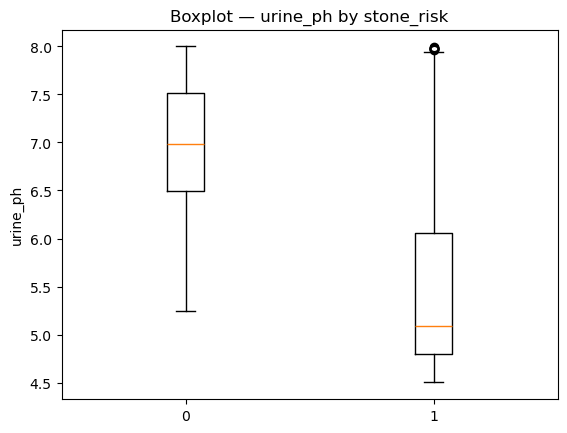

Saved boxplot for oxalate_levels → ../reports/figures/boxplot_oxalate_levels.png


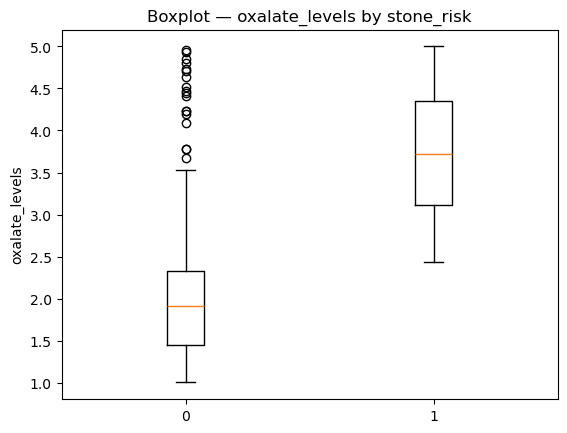

In [6]:
# Boxplots by class
for c in ['urine_ph', 'oxalate_levels']:
    if c in df.columns:
        plt.figure()
        data0 = df.loc[df['stone_risk'] == 0, c].dropna().values
        data1 = df.loc[df['stone_risk'] == 1, c].dropna().values
        plt.boxplot([data0, data1], tick_labels=['0', '1'])
        plt.title(f'Boxplot — {c} by stone_risk')
        plt.ylabel(c)
        plt.savefig(f'../reports/figures/boxplot_{c}.png', dpi=300, bbox_inches="tight")
        print(f"Saved boxplot for {c} → ../reports/figures/boxplot_{c}.png")
        plt.show()


Saved hexbin plot → ../reports/figures/hexbin_urineph_oxalate.png


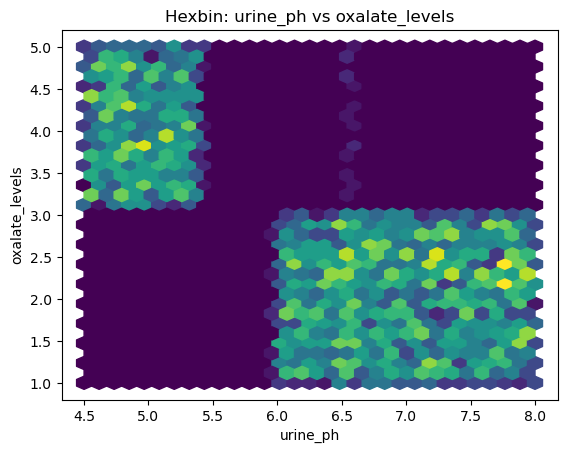

In [7]:
# Hexbin plot (if both variables exist)
if set(['urine_ph', 'oxalate_levels']).issubset(df.columns):
    plt.figure()
    plt.hexbin(df['urine_ph'], df['oxalate_levels'], gridsize=30)
    plt.xlabel('urine_ph')
    plt.ylabel('oxalate_levels')
    plt.title('Hexbin: urine_ph vs oxalate_levels')
    plt.savefig('../reports/figures/hexbin_urineph_oxalate.png', dpi=300, bbox_inches="tight")
    print("Saved hexbin plot → ../reports/figures/hexbin_urineph_oxalate.png")
    plt.show()
